# Machine Learning at Scale, Part II

For this tutorial, we'll dig deeper into BIDMach's learning architecture. The examples so far have use convenience functions which assembled together a Data Source, Learner, Model, Updater and Mixin classes to make a trainable model. This time we'll separate out those components and see how they can be customized. 

The dataset is from UCI and comprises Pubmed abstracts. It is about 7.3GB in text form. We'll compute an LDA topic model for this dataset. 

First lets initialize BIDMach again.

In [8]:
import BIDMat.{CMat,CSMat,DMat,Dict,IDict,Image,FMat,FND,GDMat,GMat,GIMat,GSDMat,GSMat,
               HMat,IMat,Mat,SMat,SBMat,SDMat}
import BIDMat.MatFunctions._
import BIDMat.SciFunctions._
import BIDMat.Solvers._
import BIDMat.Plotting._
import BIDMach.Learner
import BIDMach.models.{FM,GLM,KMeans,KMeansw,ICA,LDA,LDAgibbs,Model,NMF,RandomForest,SFA,SVD}
import BIDMach.datasources.{DataSource,MatSource,FileSource,SFileSource}
import BIDMach.mixins.{CosineSim,Perplexity,Top,L1Regularizer,L2Regularizer}
import BIDMach.updaters.{ADAGrad,Batch,BatchNorm,IncMult,IncNorm,Telescoping}
import BIDMach.causal.{IPTW}

Mat.checkMKL
Mat.checkCUDA
Mat.inline = true
if (Mat.hasCUDA > 0) GPUmem

1 CUDA device found, CUDA version 7.0


(0.9901006,11959820288,12079398912)

Check the GPU memory again, and make sure you dont have any dangling processes.

## Large-scale Topic Models

A **Topic model** is a representation of a Bag-Of-Words corpus as several factors or topics. Each topic should represent a theme that recurs in the corpus. Concretely, the output of the topic model will be an (ntopics x nfeatures) matrix we will call <code>tmodel</code>. Each row of that matrix represents a topic, and the elements of that row are word probabilities for the topic (i.e. the rows sum to 1). There is more about topic models <a href="http://en.wikipedia.org/wiki/Topic_model">here on wikipedia</a>.

The **element <code>tmodel(i,j)</code> holds the probability that word j belongs to topic i**. Later we will examine the topics directly and try to make sense of them.

Lets construct a learner with a files data source. Most model classes will accept a String argument, and assume it is a pattern for accessing a collection of files. To create the learner, we pass this pattern (which will be invoked with <string> format i) to enumerate one filename. 

In [4]:
val mdir = "../data/uci/pubmed_parts/";
val (nn, opts) = LDA.learner(mdir+"part%02d.smat.lz4")

BIDMach.models.LDA$FileOpts@484d3b4b

Note that this dataset is quite large, and isnt one of the ones loaded by <code>getdata.sh</code> in the <code>scripts</code> directory. You need to run the script <code>getpubmed.sh</code> separately (and plan a long walk or bike ride while you wait...). 

This datasource uses just this sequence of files, and each matrix has 141043 rows. A number of options are listed below that control the files datasource. Most of these dont need to be set (you'll notice they're just set to their default values), but its useful to know about them for customizing data sources. 

In [5]:
opts.nstart = 0;                 // Starting file number
opts.nend = 10;                  // Ending file number
opts.order = 0;                  // (0) sample order, 0=linear, 1=random
opts.lookahead = 2;              // (2) number of prefetch threads
opts.featType = 1;               // (1) feature type, 0=binary, 1=linear
// These are specific to SfilesDS:
opts.fcounts = icol(141043);     // how many rows to pull from each input matrix 
opts.eltsPerSample = 300         // how many rows to allocate (non-zeros per sample)

300

We're ready to go. LDA is a popular topic model, described <a href="http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation">here on wikipedia</a>.

We use a fast version of LDA which uses an incremental multiplicative update described by Hoffman, Blei and Bach 
<a href="https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf">here</a>

### Tuning Options

Add tuning options for minibatch size (say 100k), number of passes (4) and dimension (<code>dim = 256</code>). 

In [6]:
opts.batchSize=50000
opts.npasses=2
opts.dim=256

256

You invoke the learner the same way as before. You can change the options above after each run to optimize performance. 

In [7]:
nn.train

corpus perplexity=9554.363735
pass= 0
 1.00%, ll=-8.62921, gf=23.559, secs=1.3, GB=0.04, MB/s=31.12, GPUmem=0.915805
 7.00%, ll=-7.21317, gf=32.201, secs=6.5, GB=0.27, MB/s=41.13, GPUmem=0.915805
14.00%, ll=-7.07097, gf=31.597, secs=12.3, GB=0.50, MB/s=40.25, GPUmem=0.915805
21.00%, ll=-6.99212, gf=32.130, secs=17.7, GB=0.72, MB/s=40.89, GPUmem=0.915805
28.00%, ll=-6.99992, gf=32.353, secs=23.1, GB=0.95, MB/s=41.15, GPUmem=0.915805
34.00%, ll=-6.97847, gf=32.439, secs=28.6, GB=1.18, MB/s=41.24, GPUmem=0.915805
41.00%, ll=-6.91536, gf=32.750, secs=33.8, GB=1.41, MB/s=41.63, GPUmem=0.915805
48.00%, ll=-6.95439, gf=32.799, secs=39.2, GB=1.64, MB/s=41.69, GPUmem=0.915805
54.00%, ll=-6.95538, gf=32.905, secs=44.5, GB=1.86, MB/s=41.81, GPUmem=0.915805
61.00%, ll=-6.89019, gf=32.986, secs=49.9, GB=2.09, MB/s=41.91, GPUmem=0.915805
68.00%, ll=-6.93782, gf=33.076, secs=55.2, GB=2.32, MB/s=42.03, GPUmem=0.915805
75.00%, ll=-6.93163, gf=33.148, secs=60.5, GB=2.55, MB/s=42.11, GPUmem=0.915805
81.0

Each training run creates a <code>results</code> matrix which is essentially a graph of the log likelihood vs number of input samples. The first row is the likelihood values, the second is the corresponding number of input samples procesed. We can plot the results here:

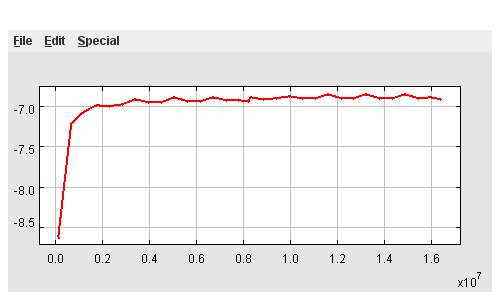

In [9]:
plot(nn.results(1,?), nn.results(0,?))

## Evaluation

To evaluate the model, we save the model matrix itself, and also load a dictionary of the terms in the corpus.

In [10]:
val tmodel = FMat(nn.modelmat)
val dict = Dict(loadSBMat(mdir+"../pubmed.term.sbmat.lz4"))

BIDMat.Dict@426d0606

The dictionary allows us to look up terms by their index, e.g. <code>dict(1000)</code>, by their string represenation <code>dict("book")</code>, and by matrices of these, e.g. <code>dict(ii)</code> where <code>ii</code> is an IMat. Try a few such queries to the dict here:

Next we evaluate the entropy of each dimension of the model. Recall that the entropy of a discrete probability distribution is $E = -\sum_{i=1}^n p_i \ln(p_i)$. The rows of the matrix are the topic probabilities.

Compute the entropies for each topic:

In [11]:
val ent = -(tmodel dotr ln(tmodel))
ent.t // put them in a horizontal line

5.3690,4.6173,5.1931,4.3272,5.0450,4.5908,5.1990,4.7400,5.4388,5.8817,3.9942,4.9691,3.4760,4.6803,5.2240,4.4261,2.6143,3.1982,5.6850,3.4297,5.6296,5.3391,3.8725,2.2650,4.6011,3.9788,5.7375,4.4867,5.0735,6.1844,4.0956,2.8332,5.4907,4.9725,3.3547,5.3487,5.6557,1.4047,3.5170,4.5044,5.7995,2.4384,4.1112,4.4545,5.4398,6.0336,4.1584,5.8070,4.9180,5.2823,5.4019,5.9175,5.3857,3.9122,5.9236,4.3411,4.1151,5.5967,5.1880,4.4677,5.7242,5.1439,4.2215,5.7330,5.0427,3.9807,1.9134,5.8287,4.9574,4.4223,1.3168,5.2260,2.5951,5.0342,5.4247,5.6248,4.6704,4.3363,5.2154,5.2817,5.0274,4.9941,3.7814,5.8868,5.6136,5.2359,4.5909,5.4422,5.2665,5.2949,4.7852,6.6557,6.5379,5.3790,5.2939,4.6287,2.0682,4.5764,4.9867,5.0565,6.4646,3.6091,2.8973,4.5669,5.4499,4.5803,4.7112,5.6246,5.1831,5.7630,5.3857,4.1282,5.1649,4.4527,5.9053,5.6804,5.0836,2.7533,4.6551,5.2569,5.0817,4.9214,5.2170,5.1846,3.7757,5.6146,3.8624,4.0365,4.7211,5.0008,5.6816,4.7475,3.5002,3.8224,5.5547,5.3043,4.8786,5.8705,4.8430,4.7702,5.3252,3.7670,5.7337

Get the mean value (should be positive)

In [12]:
mean(ent)  

4.7504

Find the smallest and largest entropy topic indices (use maxi2 and mini2). Call them <code>elargest</code> and <code>esmallest</code>.

In [13]:
val (vlargest,elargest) = maxi2(ent)
val (vsmallest,esmallest) = mini2(ent)

70

Now we'll sort the probabilities within each topic to bring the highest probability terms to the beginning. We sort down (descending order) along dimension 2 (rows) to do this. <code>bestv</code> gets the sorted values and <code>besti</code> gets the sorted indices which are the feature indices.

In [14]:
val (bestp, besti) = sortdown2(tmodel,2)

  1244  2143  3013  1414  2058  2541  4052  2173   649  4272  6756  3491...
   127   398   397   401  1109   178   977   115  2521  1998   260  3198...
   466  1117  2414  2266  4043  2892  3263  3104  5788    43  4002  5570...
   675   419  1387  2119  2321  3749  2165  3212  3805  3937  5436  4943...
   402   533   999  1072   957  2558  3145  3532     2  2680  3201  1527...
  2214  2666  1673  4530  3199  3119  3694  5270  5069  6945  3868  7725...
   494   550   766  1486  6144   267  2527  2929  4068    18  3600    93...
   328   323   703   653  1443  4601  1339  5438  6123  4044   890  7498...
    ..    ..    ..    ..    ..    ..    ..    ..    ..    ..    ..    ..


Now examine the 100 strongest terms in each topic:

In [15]:
dict(besti(elargest,0->100))

hospital,program,care,health,cost,services,health_care,need,community,nursing,service,public,decision,plan,policy,benefit,planning,economic,organization,new,impact,nurses,management,national,goal,facilities,resources,issues,control,law,institution,personnel,process,home,article,mental_health,nurse,professional,unit,provide,social,under,legal,financial,effort,development,pharmacy,quality,strategies,medicare,demand,provision,utilization,project,center,federal,payment,implementation,act,effective,provider,public_health,staff,market,setting,government,intervention,prevention,ethical,health_services,private,individual,major,policies,responsibility,medical,requirement,regulation,objectives,court,facility,insurance,current,delivery,provided,medical_care,meet,part,standard,person,implication,product,based,concern,research,future,agencies,providing,work,saving

In [16]:
dict(besti(esmallest,0->100))

protein,basic,binding_protein,acidic,cap,mbp,major,s-100,amount,myelin,bound,scrapie,bind,membrane_protein,ubiquitin,proteolipid,retinol-binding,s100,cellular,biochemical,protein_level,protein-bound,known,specifically,appear,acid-binding,function,milligram,including,involved,constituent,prion,pmol/mg,macromolecules,saf,gfa,abundant,kilodalton,general,show,lowry,unknown,immunoblot,whole,immunologically,rich,intrinsic,common,possible,g_protein,variety,immunoblotting,scrapie-infected,hsp90,previously,identification,abundance,association,origin,fut-175,include,suggesting,immunochemical,p55,least,product,encephalitogenic,identical,unique,properties,absent,c4b-binding,tightly,anti-mbp,comparison,identify,called,bacterially,scrapie-associated,protein-free,exception,2-glycoprotein,protein-induced,protein-containing,counterpart,analyzed,biuret,microgram/mg,constitute,individual,protein-specific,property,dm-20,70-kda,interact,belong,protein-depleted,protein.abstract,similarities,neurospecific

Do you notice any difference in the coherence of these two topics?

> TODO: Fill in your answer here

By sorting the entropies, find the 2nd and 3rd smallest entropy topics. Give the top 100 terms in each topic below:

In [ ]:
val (sent, ient) = sort2(ent)
// words for 2nd lowest entropy topic
dict(besti(ient(1),0->100))

In [ ]:
// words for 3rd lowest entropy topic
dict(besti(ient(2),0->100))

## Running more topics

What would you expect to happen to the average topic entropy if you run fewer topics? 

> TODO: answer here

Change the opts.dim argument above and try it. First note the entropy at dim = 256 below. Then run again with <code>dim=64</code> and put the new value below: 

<table>
<tr>
<th>dim</th>
<th>mean entropy</th>
</tr>
<tr>
<td>64</td>
<td>...</td>
</tr>
<tr>
<td>256</td>
<td>...</td>
</tr>
</table>
